# Home Cage| Sanbox Analysis

Answering random questions

In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

from trial_class import *
from experiment_class import Experiment
from bouts_extension import *
from hc_extension import *

In [ ]:
# NAc: #15616F
# mPFC: #FFAF00

# NAc
# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac"
# csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\nac_csvs"
# brain_region = '#15616F'

# mPFC
# experiment_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc"
# csv_base_path = r"C:\Users\alber\OneDrive\Desktop\PC_Lab\Photometry\Pilot_2\Combined_Cohorts\Home_Cage\mpfc_csvs"
# brain_region = '#FFAF00'

In [2]:
experiment_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/nac"
csv_base_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all_csvs/nac_csvs"
brain_region = '#15616F'

# experiment_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc"
# csv_base_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all_csvs/mpfc_csvs"
# brain_region = '#FFAF00'

In [3]:
bout_definitions = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]


In [4]:
# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/nac/n5-240823-085032/Notes.txt
read from t=0s to t=1789.26s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/nac/nn4-250121-084228/Notes.txt
read from t=0s to t=1861.76s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/nac/nn7-250121-094048/Notes.txt
read from t=0s to t=1839.16s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/nac/nn8-250121-101912/Notes.txt
read from t=0s to t=1836.57s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/nac/nn6-250120-085156/Notes.txt
read from t=0s to t=1779.76s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/nac/n6-24082

### Check if there is a second behavioral event when you take the peak nearest to first investigation. We want to ensure you are not taking the peak of a second behavioral event.

In [5]:
experiment.reset_all_behaviors()
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = False)

# total_avg_bout_duration = metadata_df["Average Bout Duration"].mean()
# print(f"Total Average Bout Duration: {total_avg_bout_duration:.4f}")
# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, # total_avg_bout_duration 
                                  mode='standard')

Processing behaviors for p1-240508-084607...
Processing behaviors for p2-240508-101128...
Processing behaviors for p3-240509-070801...
Processing behaviors for p5-240823-093250...
Processing behaviors for p6-240823-105552...
Processing behaviors for p7-240824-053845...
Processing behaviors for p8-240824-070451...
Processing behaviors for pp1-250120-094415...
Processing behaviors for pp2-250121-123301...
Processing behaviors for pp3-250121-055222...
Processing behaviors for pp4-250121-065035...
Processing behaviors for pp5-250121-110144...
Processing behaviors for pp6-250121-114116...
Processing behaviors for pp7-250121-134131...
Processing behaviors for pp8-250121-142227...
Computing DA metrics for p1-240508-084607 ...
Computing DA metrics for p2-240508-101128 ...
Computing DA metrics for p3-240509-070801 ...
Computing DA metrics for p5-240823-093250 ...
Computing DA metrics for p6-240823-105552 ...
Computing DA metrics for p7-240824-053845 ...
Computing DA metrics for p8-240824-070451

In [6]:
exp_da_dict = get_trial_dataframes(experiment)
desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']

In [7]:
def count_peaks_past_next_investigation(exp_da_dict, behavior="Investigation"):
    """
    For each subject and bout, check if the first behavior's peak occurs
    after the second behavior's onset. Returns a nested dict:
    
    {
      subject_id: {
        bout_label: {
          "overlap": True/False,
          "absolute_peak_time": float,
          "second_onset": float
        },
        ...
      },
      ...
    }
    """
    from collections import defaultdict

    overlaps = defaultdict(dict)

    for subj, df in exp_da_dict.items():
        df_b = df[df["Behavior"] == behavior].copy()
        df_b.sort_values("Event_Start", inplace=True)

        for bout, g in df_b.groupby("Bout"):
            g = g.reset_index(drop=True)

            if len(g) < 2:
                overlaps[subj][bout] = {
                    "overlap": False,
                    "absolute_peak_time": None,
                    "second_onset": None
                }
                continue

            first = g.loc[0]
            second_onset = g.loc[1, "Event_Start"]
            absolute_peak_time = first["Event_Start"] + first["Time of Max Peak"]

            overlaps[subj][bout] = {
                "overlap": absolute_peak_time > second_onset,
                "absolute_peak_time": absolute_peak_time,
                "second_onset": second_onset
            }

    return overlaps


In [8]:
overlaps = count_peaks_past_next_investigation(exp_da_dict)

In [9]:
for subj, bouts in overlaps.items():
    for bout, info in bouts.items():
        if info["overlap"]:
            print(f"⚠️ {subj} / {bout}: 1st peak ({info['absolute_peak_time']:.2f}s) ≥ 2nd onset ({info['second_onset']:.2f}s)")


In [10]:
# exp_da_dict['nn6']

### Run anova for order effects in 3 agent experiment: DA

In [15]:
experiment.reset_all_behaviors()
experiment.group_extract_manual_annotations(bout_definitions, first_only=False)
experiment.compute_all_da_metrics(max_bout_duration=4, 
                                  mode='standard')
exp_da_dict = get_trial_dataframes(experiment)
desired_bouts = ['Short_Term-1', 'Novel-1', 'Short_Term-2', 'Long_Term-1']
da_metadata_df = create_da_metrics_first_instance(exp_da_dict, behavior="Investigation", desired_bouts=desired_bouts)

Processing behaviors for n5-240823-085032...
Processing behaviors for nn4-250121-084228...
Processing behaviors for nn7-250121-094048...
Processing behaviors for nn8-250121-101912...
Processing behaviors for nn6-250120-085156...
Processing behaviors for n6-240823-101436...
Processing behaviors for nn5-250120-081227...
Processing behaviors for nn1-250120-063024...
Processing behaviors for nn3-250121-074834...
Processing behaviors for nn2-250120-072910...
Processing behaviors for n7-240824-062103...
Computing DA metrics for n5-240823-085032 ...
Computing DA metrics for nn4-250121-084228 ...
Computing DA metrics for nn7-250121-094048 ...
Computing DA metrics for nn8-250121-101912 ...
Computing DA metrics for nn6-250120-085156 ...
Computing DA metrics for n6-240823-101436 ...
Computing DA metrics for nn5-250120-081227 ...
Computing DA metrics for nn1-250120-063024 ...
Computing DA metrics for nn3-250121-074834 ...
Computing DA metrics for nn2-250120-072910 ...
Computing DA metrics for n7-2

In [12]:
# exp_da_dict['n6'].head()

In [13]:
def assign_bout_order(exp_da_dict, desired_bouts):
    """
    Determine the presentation order of each bout per subject and
    return a mapping like:
        {
            'p1': {'Short_Term-1': 1, 'Novel-1': 2, ...},
            ...
        }
    """
    order_map = {}

    for subject_id, df in exp_da_dict.items():
        # Sort by time
        df_sorted = df.sort_values("Event_Start")
        seen = {}
        order = 1

        for _, row in df_sorted.iterrows():
            bout = row["Bout"]
            if bout in desired_bouts and bout not in seen:
                seen[bout] = order
                order += 1

        order_map[subject_id] = seen

    return order_map


def add_order_column(da_df, order_map):
    """
    Add a column "Presentation_Order" to da_df using the order_map.
    """
    order_vals = []

    for _, row in da_df.iterrows():
        subject = row["Subject"]
        bout = row["Bout"]
        order = order_map.get(subject, {}).get(bout, np.nan)
        order_vals.append(order)

    da_df = da_df.copy()
    da_df["Presentation_Order"] = order_vals
    return da_df


In [16]:
order_map = assign_bout_order(exp_da_dict, desired_bouts)
da_metadata_df = add_order_column(da_metadata_df, order_map)

In [15]:
# exp_da_dict['nn4'].head()

In [16]:
da_metadata_df.head()

,Subject,Bout,Behavior,AUC,Max Peak,Mean Z-score,Presentation_Order
0,p1,Short_Term-1,Investigation,1.587773,1.578218,1.403235,1
1,p1,Novel-1,Investigation,3.839354,2.154880,1.799729,2
2,p1,Short_Term-2,Investigation,-0.811805,-0.916075,-1.061339,3
3,p1,Long_Term-1,Investigation,0.271765,0.395254,0.099534,4
4,p2,Short_Term-1,Investigation,7.167258,1.439788,0.676152,1


In [17]:
# assume da_metadata_df already has Presentation_Order
df_ord = da_metadata_df[da_metadata_df["Bout"] != "Short_Term-1"].copy()


In [18]:
import pingouin as pg

aov = pg.rm_anova(
    data=df_ord,
    dv="Max Peak",
    within="Presentation_Order",
    subject="Subject",
    detailed=True
)
print(aov)


               Source         SS  DF        MS         F     p-unc       ng2  \
0  Presentation_Order   1.971517   2  0.985758  0.593421  0.559233  0.024238   
1               Error  46.512052  28  1.661145       NaN       NaN       NaN   

        eps  
0  0.772841  
1       NaN  


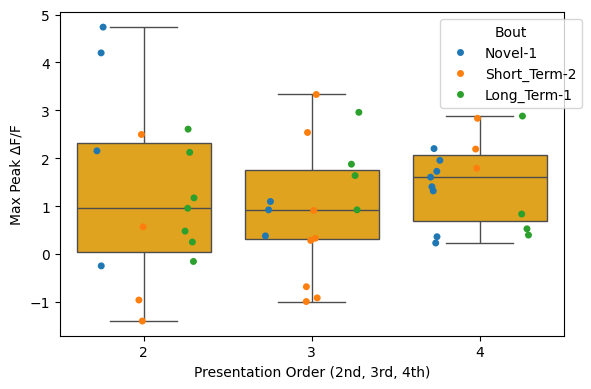

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(
    x="Presentation_Order",
    y="Max Peak",
    data=df_ord,
    color=brain_region
)
sns.stripplot(
    x="Presentation_Order",
    y="Max Peak",
    data=df_ord,
    hue="Bout",
    dodge=True,
    jitter=True
)
plt.xlabel("Presentation Order (2nd, 3rd, 4th)")
plt.ylabel("Max Peak ΔF/F")
plt.legend(bbox_to_anchor=(1.05,1), title="Bout")
plt.tight_layout()
plt.show()


### Run anova for order effects in 3 agent experiment: Total Investigation Time

In [20]:
experiment.reset_all_behaviors()
experiment.group_extract_manual_annotations(bout_definitions, first_only=False)
experiment.compute_all_da_metrics(max_bout_duration=4, 
                                  mode='standard')
exp_da_dict = get_trial_dataframes(experiment)
desired_bouts = ['Short_Term-1', 'Novel-1', 'Short_Term-2', 'Long_Term-1']
da_metadata_df = create_da_metrics_first_instance(exp_da_dict, behavior="Investigation", desired_bouts=desired_bouts)

Processing behaviors for p1-240508-084607...
Processing behaviors for p2-240508-101128...
Processing behaviors for p3-240509-070801...
Processing behaviors for p5-240823-093250...
Processing behaviors for p6-240823-105552...
Processing behaviors for p7-240824-053845...
Processing behaviors for p8-240824-070451...
Processing behaviors for pp1-250120-094415...
Processing behaviors for pp2-250121-123301...
Processing behaviors for pp3-250121-055222...
Processing behaviors for pp4-250121-065035...
Processing behaviors for pp5-250121-110144...
Processing behaviors for pp6-250121-114116...
Processing behaviors for pp7-250121-134131...
Processing behaviors for pp8-250121-142227...
Computing DA metrics for p1-240508-084607 ...
Computing DA metrics for p2-240508-101128 ...
Computing DA metrics for p3-240509-070801 ...
Computing DA metrics for p5-240823-093250 ...
Computing DA metrics for p6-240823-105552 ...
Computing DA metrics for p7-240824-053845 ...
Computing DA metrics for p8-240824-070451

In [21]:
# Step 1: Get trial data
trial_data = get_trial_dataframes(experiment)

# Step 2: Trim Short_Term-1 to first 5 minutes
trimmed_data = trim_short_term_to_5min(trial_data)

# Step 3: Create metadata dataframe with trimmed data
metadata_df = create_metadata_dataframe(trimmed_data, behavior="Investigation")
metadata_df.head()

,Subject,Bout,Behavior,Total Investigation Time,Average Bout Duration
0,p1,Long_Term-1,Investigation,31.599,2.257071
1,p1,Novel-1,Investigation,25.534,2.127833
2,p1,Short_Term-2,Investigation,33.001,3.666778
3,p1,Short_Term-1,Investigation,76.400,4.021053
4,p2,Long_Term-1,Investigation,60.931,3.046550


In [22]:
order_map = assign_bout_order(exp_da_dict, desired_bouts)
metadata_df = add_order_column(metadata_df, order_map)

In [29]:
metadata_df

,Subject,Bout,Behavior,Total Investigation Time,Average Bout Duration,Presentation_Order
0,p1,Long_Term-1,Investigation,31.599,2.257071,4
1,p1,Novel-1,Investigation,25.534,2.127833,2
2,p1,Short_Term-2,Investigation,33.001,3.666778,3
3,p1,Short_Term-1,Investigation,76.400,4.021053,1
4,p2,Long_Term-1,Investigation,60.931,3.046550,3
5,p2,Novel-1,Investigation,36.932,5.276000,4
6,p2,Short_Term-2,Investigation,14.729,1.472900,2
7,p2,Short_Term-1,Investigation,41.129,4.112900,1
8,p3,Long_Term-1,Investigation,34.001,2.428643,2
9,p3,Novel-1,Investigation,21.468,3.066857,4


In [23]:
# assume da_metadata_df already has Presentation_Order
df_ord = metadata_df[metadata_df["Bout"] != "Short_Term-1"].copy()


In [24]:
df_ord.head()

,Subject,Bout,Behavior,Total Investigation Time,Average Bout Duration,Presentation_Order
0,p1,Long_Term-1,Investigation,31.599,2.257071,4
1,p1,Novel-1,Investigation,25.534,2.127833,2
2,p1,Short_Term-2,Investigation,33.001,3.666778,3
4,p2,Long_Term-1,Investigation,60.931,3.046550,3
5,p2,Novel-1,Investigation,36.932,5.276000,4


In [25]:
import pingouin as pg

aov = pg.rm_anova(
    data=df_ord,
    dv="Total Investigation Time",
    within="Presentation_Order",
    subject="Subject",
    detailed=True
)
print(aov)


               Source            SS  DF          MS         F     p-unc  \
0  Presentation_Order   1475.208741   2  737.604371  1.242531  0.304084   
1               Error  16621.655586  28  593.630557       NaN       NaN   

        ng2       eps  
0  0.052781  0.948568  
1       NaN       NaN  


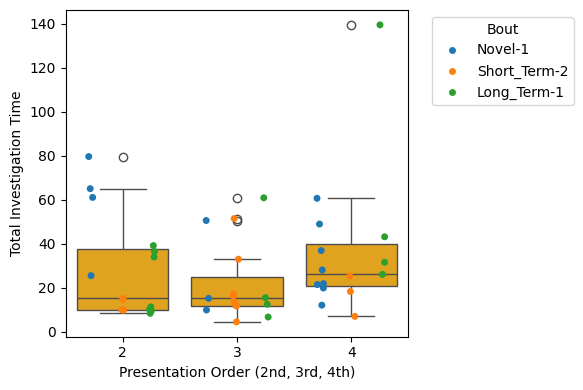

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(
    x="Presentation_Order",
    y="Total Investigation Time",
    data=df_ord,
    color=brain_region
)
sns.stripplot(
    x="Presentation_Order",
    y="Total Investigation Time",
    data=df_ord,
    hue="Bout",
    dodge=True,
    jitter=True
)
plt.xlabel("Presentation Order (2nd, 3rd, 4th)")
plt.ylabel("Total Investigation Time")
plt.legend(bbox_to_anchor=(1.05,1), title="Bout")
plt.tight_layout()
plt.show()


In [27]:
import pingouin as pg

aov = pg.rm_anova(
    data=df_ord,
    dv="Average Bout Duration",
    within="Presentation_Order",
    subject="Subject",
    detailed=True
)
print(aov)


               Source          SS  DF        MS         F     p-unc  \
0  Presentation_Order   15.208159   2  7.604079  1.224596  0.309137   
1               Error  173.864826  28  6.209458       NaN       NaN   

   p-GG-corr       ng2       eps sphericity   W-spher   p-spher  
0   0.301314  0.050832  0.724683      False  0.620086  0.044765  
1        NaN       NaN       NaN        NaN       NaN       NaN  


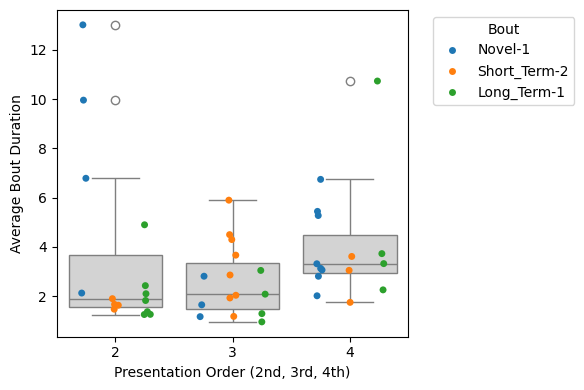

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(
    x="Presentation_Order",
    y="Average Bout Duration",
    data=df_ord,
    color="lightgray"
)
sns.stripplot(
    x="Presentation_Order",
    y="Average Bout Duration",
    data=df_ord,
    hue="Bout",
    dodge=True,
    jitter=True
)
plt.xlabel("Presentation Order (2nd, 3rd, 4th)")
plt.ylabel("Average Bout Duration")
plt.legend(bbox_to_anchor=(1.05,1), title="Bout")
plt.tight_layout()
plt.show()


# % TIT vs DA

In [5]:
experiment.reset_all_behaviors()
experiment.group_extract_manual_annotations(bout_definitions=bout_definitions, first_only = False)

# total_avg_bout_duration = metadata_df["Average Bout Duration"].mean()
# print(f"Total Average Bout Duration: {total_avg_bout_duration:.4f}")
# Proceed with DA metric computation after all files are processed
experiment.compute_all_da_metrics(use_max_length=False,
                                  max_bout_duration=4, # total_avg_bout_duration 
                                  mode='standard')

Processing behaviors for n5-240823-085032...
Processing behaviors for nn4-250121-084228...
Processing behaviors for nn7-250121-094048...
Processing behaviors for nn8-250121-101912...
Processing behaviors for nn6-250120-085156...
Processing behaviors for n6-240823-101436...
Processing behaviors for nn5-250120-081227...
Processing behaviors for nn1-250120-063024...
Processing behaviors for nn3-250121-074834...
Processing behaviors for nn2-250120-072910...
Processing behaviors for n7-240824-062103...
Computing DA metrics for n5-240823-085032 ...
Computing DA metrics for nn4-250121-084228 ...
Computing DA metrics for nn7-250121-094048 ...
Computing DA metrics for nn8-250121-101912 ...
Computing DA metrics for nn6-250120-085156 ...
Computing DA metrics for n6-240823-101436 ...
Computing DA metrics for nn5-250120-081227 ...
Computing DA metrics for nn1-250120-063024 ...
Computing DA metrics for nn3-250121-074834 ...
Computing DA metrics for nn2-250120-072910 ...
Computing DA metrics for n7-2

In [6]:
exp_da_dict = get_trial_dataframes(experiment)
desired_bouts = ['s1-1', 's1-2', 's1-3', 's1-4', 's1-5', 's2-1']

In [7]:
print(exp_da_dict)

{'n5':              Bout       Behavior  Event_Start  Event_End  Duration (s)  \
0     Long_Term-1       Approach       1480.8   1481.999         1.199   
1     Long_Term-1  Investigation       1469.9   1479.700         9.800   
2     Long_Term-1  Investigation       1482.0   1485.900         3.900   
3     Long_Term-1  Investigation       1489.2   1489.500         0.300   
4     Long_Term-1  Investigation       1502.4   1503.500         1.100   
..            ...            ...          ...        ...           ...   
124  Short_Term-2  Investigation       1094.6   1095.699         1.099   
125  Short_Term-2  Investigation       1097.5   1105.600         8.100   
126  Short_Term-2  Investigation       1106.9   1107.399         0.499   
127  Short_Term-2  Investigation       1111.9   1115.200         3.300   
128  Short_Term-2  Investigation       1130.3   1131.900         1.600   

           AUC  Max Peak  Time of Max Peak  Mean Z-score  Adjusted End  \
0    -0.821838 -0.121272      

In [11]:
def compute_percent_investigation_time_four_agents(exp_da_dict):
    import pandas as pd

    records = []

    for subject, df in exp_da_dict.items():
        df = df.copy()
        df['Bout'] = df['Bout'].astype(str)
        df['Behavior'] = df['Behavior'].astype(str)

        # Filter only 'Investigation' behaviors
        df = df[df['Behavior'].str.lower() == 'investigation']
        if df.empty:
            continue

        # Filter for the specific 4 agents
        relevant_bouts = ['Short_Term-1', 'Short_Term-2', 'Novel-1', 'Long_Term-1']
        df = df[df['Bout'].isin(relevant_bouts)]

        total_time = df['Duration (s)'].sum()
        if total_time == 0:
            continue

        # Compute summed durations
        bout_sums = df.groupby('Bout')['Duration (s)'].sum().to_dict()

        percent_st1 = bout_sums.get('Short_Term-1', 0) / total_time * 100
        percent_st2 = bout_sums.get('Short_Term-2', 0) / total_time * 100
        percent_novel = bout_sums.get('Novel-1', 0) / total_time * 100
        percent_long = bout_sums.get('Long_Term-1', 0) / total_time * 100

        records.append({
            'Subject': subject,
            '%_Short_Term-1': percent_st1,
            '%_Short_Term-2': percent_st2,
            '%_Novel': percent_novel,
            '%_Long_Term': percent_long
        })

    return pd.DataFrame(records)


percent_df = compute_percent_investigation_time_four_agents(exp_da_dict)
percent_df

,Subject,%_Short_Term-1,%_Short_Term-2,%_Novel,%_Long_Term
0,n5,57.789916,18.866401,15.977869,7.365815
1,nn4,38.645161,8.516129,35.354839,17.483871
2,nn7,54.694476,15.486252,10.873326,18.945946
3,nn8,51.888545,8.544892,28.792570,10.773994
4,nn6,60.579710,6.086957,33.333333,0.000000
5,n6,35.346359,18.650089,37.921847,8.081705
6,nn5,51.434644,4.144527,40.063762,4.357067
7,nn1,43.959519,10.689437,35.610373,9.740670
8,nn3,50.772889,14.684899,25.743163,8.799049
9,nn2,45.072993,11.861314,33.211679,9.854015


In [24]:
def build_da_summary_dataframe(exp_da_dict, first_only=True):
    """
    Build a summary DA dataframe from exp_da_dict, where each value is a DA DataFrame per subject.

    Parameters:
    - exp_da_dict: dict mapping subject IDs to DA DataFrames
    - first_only (bool): If True, take first bout per agent. If False, average across bouts.

    Returns:
    - DataFrame with columns: Subject, Agent, Max Peak, Mean Z-score, AUC
    """
    import pandas as pd

    records = []

    for subject_id, df in exp_da_dict.items():
        if df is None or df.empty:
            continue

        df = df.copy()
        df["Subject"] = subject_id.lower()
        df["Agent"] = df["Bout"].astype(str).str.strip()

        if first_only:
            grouped = df.groupby("Agent", as_index=False).first()
        else:
            grouped = df.groupby("Agent", as_index=False).agg({
                "Max Peak": "mean",
                "Mean Z-score": "mean",
                "AUC": "mean"
            })
            grouped["Subject"] = subject_id.lower()

        records.append(grouped[["Subject", "Agent", "Max Peak", "Mean Z-score", "AUC"]])

    if not records:
        print("⚠️ No valid DA data found.")
        return pd.DataFrame(columns=["Subject", "Agent", "Max Peak", "Mean Z-score", "AUC"])

    return pd.concat(records, ignore_index=True)


da_metadata_df = build_da_summary_dataframe(exp_da_dict, first_only=True)
da_metadata_df

,Subject,Agent,Max Peak,Mean Z-score,AUC
0,n5,Long_Term-1,-0.121272,-0.685884,-0.821838
1,n5,Novel-1,0.920786,-0.106338,-2.190764
2,n5,Short_Term-1,-1.287168,-1.477716,-2.953046
3,n5,Short_Term-2,0.535097,0.193084,0.250809
4,nn4,Long_Term-1,1.384913,1.272803,1.632984
5,nn4,Novel-1,4.590438,1.067696,3.413008
6,nn4,Short_Term-1,0.423399,-0.659021,-1.053693
7,nn4,Short_Term-2,0.465975,-0.343560,-0.824175
8,nn7,Long_Term-1,0.108231,-0.138414,-0.318057
9,nn7,Novel-1,2.865129,2.453977,6.378989


In [12]:
def plot_avg_da_vs_percent_total_investigation(
    dopamine_df,
    percent_df,  # df with columns: Subject, %_Short_Term-1, %_Short_Term-2, %_Novel, %_Long_Term
    agent_of_interest,
    agent_color="deeppink",
    agent_label=None,
    da_metric="Max Peak",
    use_first_only=True,
    title=None,
    ylabel="Peak Z-scored ∆F/F",
    xlabel="% Total Investigation Time",
    figsize=(10, 7),
    ylim=None,
    yticks_increment=None,
    legend_loc='upper right',
    pad_inches=0.1,
    save=False,
    save_name=None
):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    from scipy.stats import linregress

    agent = agent_of_interest.strip()
    percent_col = f"%_{agent}"

    # Prep
    dopamine_df = dopamine_df.copy()
    dopamine_df["Subject"] = dopamine_df["Subject"].astype(str).str.lower()
    dopamine_df["Agent"] = dopamine_df["Agent"].astype(str).str.strip()

    percent_df = percent_df.copy()
    percent_df["Subject"] = percent_df["Subject"].astype(str).str.lower()

    # Subset dopamine data to just that agent
    da_sub = dopamine_df[dopamine_df["Agent"] == agent]
    if use_first_only:
        da_sub = da_sub.groupby("Subject", as_index=False).first()
    else:
        da_sub = da_sub.groupby("Subject", as_index=False)[da_metric].mean()

    # Merge with percent investigation
    merged = pd.merge(da_sub, percent_df[["Subject", percent_col]], on="Subject", how="inner")
    merged = merged.rename(columns={percent_col: "PercentTime"})

    if merged.empty:
        print("⚠️ No data to plot after merging.")
        return pd.DataFrame()

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)

    x = merged["PercentTime"]
    y = merged[da_metric]

    ax.scatter(x, y, color=agent_color, s=250, alpha=1.0, edgecolor='black', linewidth=3, label=agent_label or agent, zorder=3)

    stats_text_lines = ["r = ---", "p = ---", "n = ---"]
    if len(set(x)) > 1:
        slope, intercept, r_val, p_val, _ = linregress(x, y)
        x_fit = np.linspace(min(x), max(x), 100)
        y_fit = slope * x_fit + intercept
        ax.plot(x_fit, y_fit, color='black', linewidth=2.5, linestyle='-', zorder=2)
        stats_text_lines = [
            f"r = {r_val:.3f}",
            f"p = {p_val:.3f}",
            f"n = {len(x)} points"
        ]

    ax.set_xlabel(xlabel, fontsize=24)
    ax.set_ylabel(ylabel, fontsize=24)
    ax.set_title(title or f"{agent} vs DA", fontsize=26)
    ax.tick_params(axis='both', labelsize=24)

    if ylim:
        ax.set_ylim(ylim)
    if yticks_increment:
        y_min, y_max = ax.get_ylim()
        yticks = np.arange(np.floor(y_min), np.ceil(y_max) + yticks_increment, yticks_increment)
        ax.set_yticks(yticks)

    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}'))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x)}' if x.is_integer() else f'{x:.1f}'))

    handles, labels = ax.get_legend_handles_labels()
    stats_handle = plt.Line2D([], [], color='none', label="\n".join(stats_text_lines))
    handles.append(stats_handle)
    labels.append("\n".join(stats_text_lines))

    legend = ax.legend(handles=handles, labels=labels, loc=legend_loc, fontsize=16, title='Agent', title_fontsize=18,
                       frameon=True, facecolor='white', edgecolor='lightgray', fancybox=False)
    legend.get_frame().set_alpha(0.8)

    plt.tight_layout()
    if save:
        if save_name is None:
            raise ValueError("save_name must be provided if save is True.")
        plt.savefig(save_name, transparent=True, bbox_inches='tight', pad_inches=pad_inches)

    plt.show()
    return merged


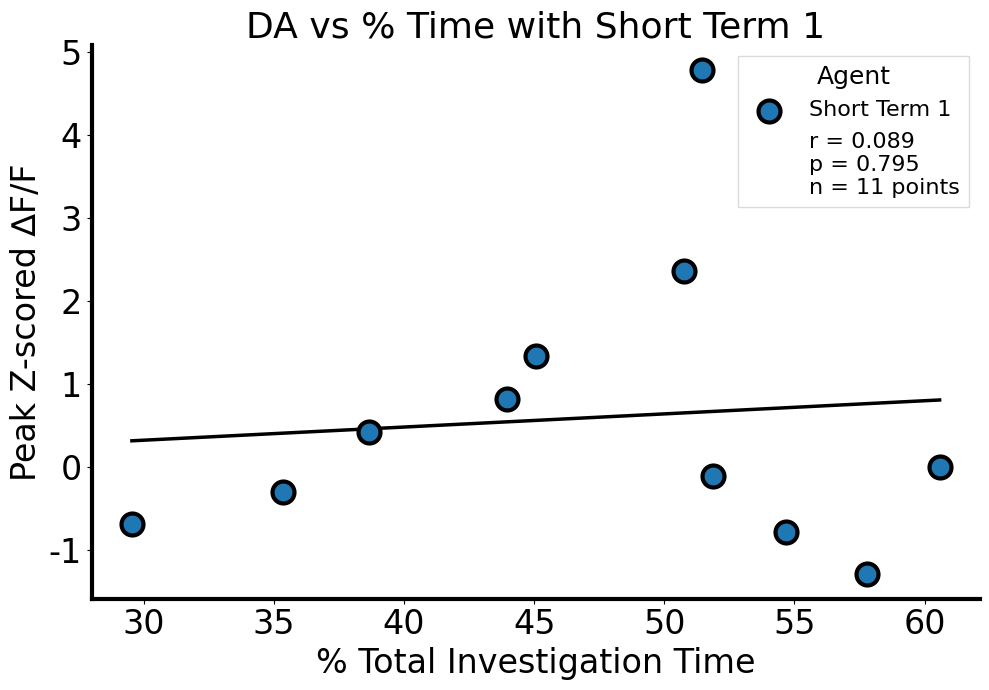

,Subject,Agent,Max Peak,Mean Z-score,AUC,PercentTime
0,n5,Short_Term-1,-1.287168,-1.477716,-2.953046,57.789916
1,n6,Short_Term-1,-0.299384,-0.464953,-0.743251,35.346359
2,n7,Short_Term-1,-0.694718,-0.792111,-0.949216,29.545455
3,nn1,Short_Term-1,0.822117,-0.087355,-0.226971,43.959519
4,nn2,Short_Term-1,1.338588,0.974495,1.849743,45.072993
5,nn3,Short_Term-1,2.356267,0.768938,1.383457,50.772889
6,nn4,Short_Term-1,0.423399,-0.659021,-1.053693,38.645161
7,nn5,Short_Term-1,4.776771,3.815224,6.327551,51.434644
8,nn6,Short_Term-1,-0.003979,-0.360870,-0.829145,60.579710
9,nn7,Short_Term-1,-0.783902,-0.997294,-1.294069,54.694476


In [29]:
plot_avg_da_vs_percent_total_investigation(
    dopamine_df=da_metadata_df,
    percent_df=percent_df,  # your %_Short_Term-1, etc df
    agent_of_interest="Short_Term-1",
    agent_color="#1f77b4",
    agent_label="Short Term 1",
    da_metric="Max Peak",
    title="DA vs % Time with Short Term 1",
    ylabel="Peak Z-scored ∆F/F",
    legend_loc="upper right"
)


# ABD as max bout duration for AUC DA

In [46]:
# experiment_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/nac"
# csv_base_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all_csvs/nac_csvs"
# brain_region = '#15616F'

experiment_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc"
csv_base_path = "/Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all_csvs/mpfc_csvs"
brain_region = '#FFAF00'

# groups csv + experiment data into one variable
experiment = Experiment(experiment_path, csv_base_path)

# batch process the data, removing the specified time segments for subjects
experiment.default_batch_process()

Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/p6-240823-105552/Notes.txt
read from t=0s to t=1807.06s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/p2-240508-101128/Notes.txt
read from t=0s to t=1820.76s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/pp4-250121-065035/Notes.txt
read from t=0s to t=1876.76s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/p7-240824-053845/Notes.txt
read from t=0s to t=1790.87s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/pp5-250121-110144/Notes.txt
read from t=0s to t=1895.67s
Found Synapse note file: /Users/naylajimenez/Downloads/papers/dopamine/cohort-1-2/allcohorts/C1_2_3_Home_Cage/all/mpfc/pp3-

In [47]:
bout_definitions = [
    {'prefix': 'Short_Term', 'introduced': 'Short_Term_Introduced', 'removed': 'Short_Term_Removed'},
    {'prefix': 'Long_Term', 'introduced': 'Long_Term_Introduced', 'removed': 'Long_Term_Removed'},
    {'prefix': 'Novel', 'introduced': 'Novel_Introduced', 'removed': 'Novel_Removed'}
]

experiment.group_extract_manual_annotations(bout_definitions, first_only=False)

# Step 1: Get trial data
trial_data = get_trial_dataframes(experiment)

# Step 2: Trim Short_Term-1 to first 5 minutes
trimmed_data = trim_short_term_to_5min(trial_data)

# Step 3: Create metadata dataframe with trimmed data
metadata_df = create_metadata_dataframe(trimmed_data, behavior="Investigation")
metadata_df

Processing behaviors for p6-240823-105552...
Processing behaviors for p2-240508-101128...
Processing behaviors for pp4-250121-065035...
Processing behaviors for p7-240824-053845...
Processing behaviors for pp5-250121-110144...
Processing behaviors for pp3-250121-055222...
Processing behaviors for pp1-250120-094415...
Processing behaviors for pp6-250121-114116...
Processing behaviors for p1-240508-084607...
Processing behaviors for pp7-250121-134131...
Processing behaviors for pp8-250121-142227...
Processing behaviors for p5-240823-093250...
Processing behaviors for p3-240509-070801...
Processing behaviors for p8-240824-070451...
Processing behaviors for pp2-250121-123301...


,Subject,Bout,Behavior,Total Investigation Time,Average Bout Duration
0,p6,Long_Term-1,Investigation,15.500,1.291667
1,p6,Novel-1,Investigation,60.700,6.744444
2,p6,Short_Term-2,Investigation,9.800,1.633333
3,p6,Short_Term-1,Investigation,22.700,2.522222
4,p2,Long_Term-1,Investigation,60.931,3.046550
5,p2,Novel-1,Investigation,38.999,5.571286
6,p2,Short_Term-2,Investigation,14.729,1.472900
7,p2,Short_Term-1,Investigation,41.129,4.112900
8,pp4,Long_Term-1,Investigation,12.500,2.083333
9,pp4,Novel-1,Investigation,65.100,13.020000


In [48]:
experiment.compute_all_da_metrics(max_bout_duration=10, 
                                  mode='standard')

Computing DA metrics for p6-240823-105552 ...
Computing DA metrics for p2-240508-101128 ...
Computing DA metrics for pp4-250121-065035 ...
Computing DA metrics for p7-240824-053845 ...
Computing DA metrics for pp5-250121-110144 ...
Computing DA metrics for pp3-250121-055222 ...
Computing DA metrics for pp1-250120-094415 ...
Computing DA metrics for pp6-250121-114116 ...
Computing DA metrics for p1-240508-084607 ...
Computing DA metrics for pp7-250121-134131 ...
Computing DA metrics for pp8-250121-142227 ...
Computing DA metrics for p5-240823-093250 ...
Computing DA metrics for p3-240509-070801 ...
Computing DA metrics for p8-240824-070451 ...
Computing DA metrics for pp2-250121-123301 ...


In [49]:
def recompute_da_metrics_per_bout(experiment, avg_duration_df, mode='standard', post_time=15):
    """
    Recomputes DA metrics for each bout using its corresponding average duration.

    Parameters:
    - experiment: Experiment object with trials.
    - avg_duration_df: DataFrame with 'Subject', 'Bout', 'Average Bout Duration' columns.
    - mode: 'standard' or 'EI' for computing DA metrics.
    - post_time: Seconds to extend window after bout end.
    """
    for trial_name, trial in experiment.trials.items():
        if not hasattr(trial, 'behaviors') or trial.behaviors.empty:
            print(f"⚠️ Trial {trial_name} has no behaviors.")
            continue

        subj_id = trial_name.lower().split("-")[0]
        trial_df = trial.behaviors.copy()

        if 'Bout' not in trial_df.columns:
            print(f"⚠️ Trial {trial_name} missing 'Bout' column.")
            continue

        # Prepare durations per bout from avg_duration_df
        trial_df = trial_df.copy()
        trial_df["Subject"] = trial_name  # Add subject column before merging

        merged = trial_df.merge(
            avg_duration_df,
            how='left',
            on=['Subject', 'Bout']
)

        if 'Average Bout Duration' not in merged.columns:
            print(f"❌ Could not find average duration for trial {trial_name}. Skipping.")
            continue

        # Iterate through each bout individually
        for i, row in merged.iterrows():
            temp_df = pd.DataFrame([row])
            trial.behaviors = temp_df  # overwrite temporarily

            trial.compute_da_metrics(
                use_max_length=True,
                max_bout_duration=row['Average Bout Duration'],
                mode=mode,
                post_time=post_time
            )

        # Restore original behaviors
        trial.behaviors = trial_df
        print(f"✅ Recomputed DA metrics for {trial_name} using average durations per Bout.")

recompute_da_metrics_per_bout(
    experiment=experiment,           # your loaded experiment object
    avg_duration_df=metadata_df,     # must include columns: 'Subject', 'Bout', 'Average Bout Duration'
    mode='standard',                 # or 'EI' if using event-aligned windows
    post_time=15                     # optional tail window after each bout
)

✅ Recomputed DA metrics for p6-240823-105552 using average durations per Bout.
✅ Recomputed DA metrics for p2-240508-101128 using average durations per Bout.
✅ Recomputed DA metrics for pp4-250121-065035 using average durations per Bout.
✅ Recomputed DA metrics for p7-240824-053845 using average durations per Bout.
✅ Recomputed DA metrics for pp5-250121-110144 using average durations per Bout.
✅ Recomputed DA metrics for pp3-250121-055222 using average durations per Bout.
✅ Recomputed DA metrics for pp1-250120-094415 using average durations per Bout.
✅ Recomputed DA metrics for pp6-250121-114116 using average durations per Bout.
✅ Recomputed DA metrics for p1-240508-084607 using average durations per Bout.
✅ Recomputed DA metrics for pp7-250121-134131 using average durations per Bout.
✅ Recomputed DA metrics for pp8-250121-142227 using average durations per Bout.
✅ Recomputed DA metrics for p5-240823-093250 using average durations per Bout.
✅ Recomputed DA metrics for p3-240509-070801 

In [50]:
exp_da_dict = get_trial_dataframes(experiment)

desired_bouts = ['Short_Term-1', 'Novel-1', 'Short_Term-2', 'Long_Term-1']
da_metadata_df = create_da_metrics_dataframe(exp_da_dict, behavior="Investigation", desired_bouts=desired_bouts)

# Copy original DataFrame
ordered_df = da_metadata_df.copy()

# Desired bout order
desired_bout_order = ["Short_Term-1", "Short_Term-2", "Long_Term-1", "Novel-1"]

# 1. Filter and reorder Bout as categorical
ordered_df = ordered_df[ordered_df["Bout"].isin(desired_bout_order)].copy()
ordered_df["Bout"] = pd.Categorical(ordered_df["Bout"], categories=desired_bout_order, ordered=True)
da_metadata_df

,Subject,Bout,Behavior,AUC,Max Peak,Mean Z-score
0,p6,Short_Term-1,Investigation,-1.135212,0.027777,-0.347366
1,p6,Novel-1,Investigation,-0.579498,0.615743,-0.141132
2,p6,Short_Term-2,Investigation,-0.355056,-0.344930,-0.614609
3,p6,Long_Term-1,Investigation,0.074824,0.344757,0.084570
4,p2,Short_Term-1,Investigation,1.415458,1.229817,0.746498
5,p2,Novel-1,Investigation,2.446672,0.948517,0.415742
6,p2,Short_Term-2,Investigation,0.334392,0.555942,0.277308
7,p2,Long_Term-1,Investigation,-0.016863,0.295615,-0.052517
8,pp4,Short_Term-1,Investigation,-0.209751,0.945593,0.440766
9,pp4,Novel-1,Investigation,3.829462,1.767849,0.633540


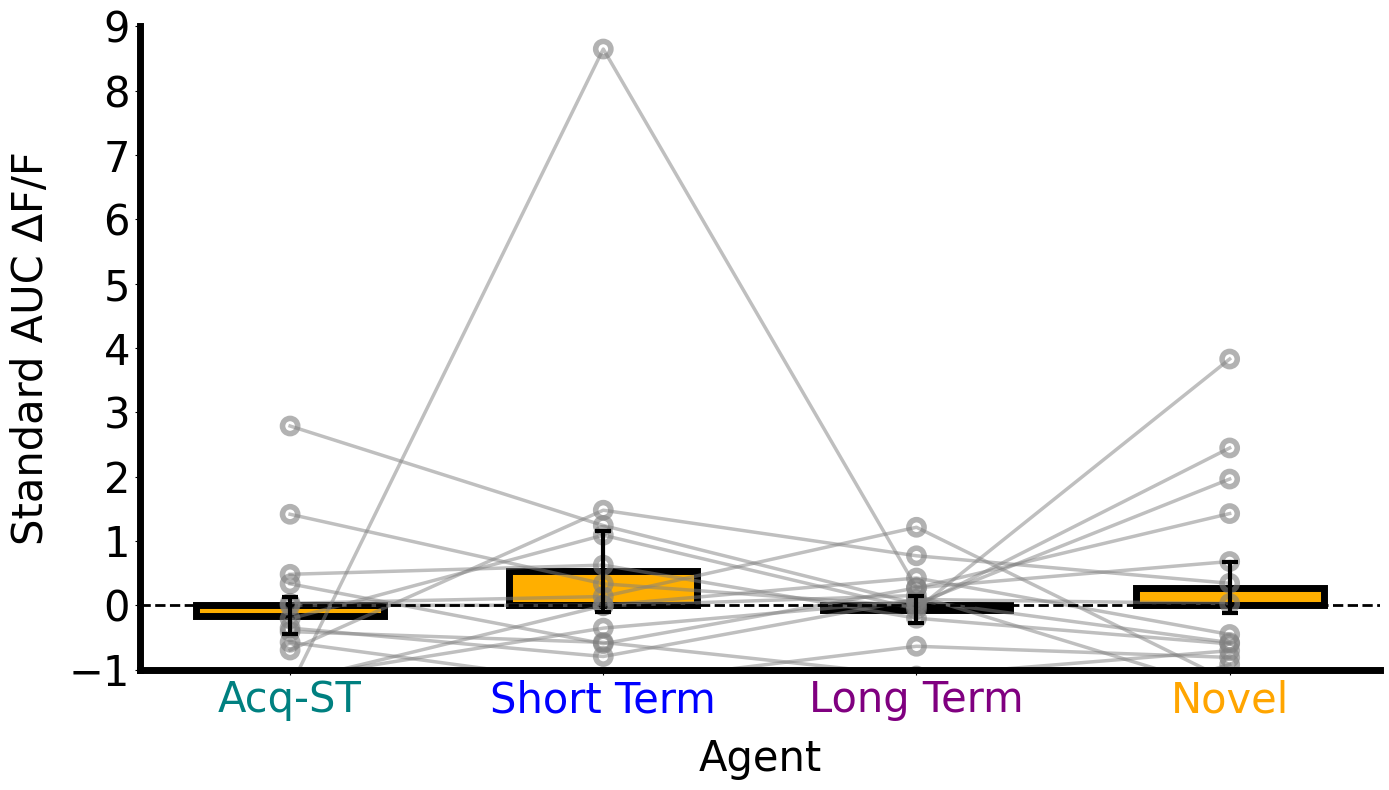


Paired t-test results (all pairwise combinations):
Short_Term-1 vs Short_Term-2: p = 0.3473 (ns)
Short_Term-1 vs Long_Term-1: p = 0.7758 (ns)
Short_Term-1 vs Novel-1: p = 0.2289 (ns)
Short_Term-2 vs Long_Term-1: p = 0.3272 (ns)
Short_Term-2 vs Novel-1: p = 0.7027 (ns)
Long_Term-1 vs Novel-1: p = 0.4203 (ns)


In [54]:
plot_behavior_across_bouts_no_identities(
    metadata_df=ordered_df,
    y_col="AUC",
    ylabel="Standard AUC ∆F/F",
    xlabel="Agent",
    custom_xtick_labels=["Acq-ST", "Short Term", "Long Term", "Novel"],
    custom_xtick_colors=["teal", "blue", "purple", "orange"],
    ylim=(-1, 9),
    yticks_increment=1,
    bar_color=brain_region,
    figsize=(14, 8),
    save=None,
    save_name ="mDA",
    title=None
)